In [1]:
import sys
sys.path.insert(0, "../lib")

In [2]:
import math
import os
import pathlib
import re

import scanpy as sc
import numpy as np
import pandas as pd
import sc_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
import torch
import scipy
import statsmodels.stats.multitest

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
FONT_DIR = '/projects/b1038/Pulmonary/nmarkov/fonts'
for f in os.listdir(FONT_DIR):
    if f.endswith('.ttf'):
        mpl.font_manager.fontManager.addfont(f'{FONT_DIR}/{f}')

In [5]:
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42
# mpl.rcParams['mathtext.default'] = 'regular'

In [6]:
pd.options.display.max_rows = 200

In [7]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        if pd.api.types.is_numeric_dtype(df[column]):
            values = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
            if not isinstance(palette, mpl.colors.Colormap):
                palette = sns.color_palette(palette, as_cmap=True)
            colors = palette(values)
            colors = [mpl.colors.to_hex(color) for color in colors]
            colors = pd.Series(colors, index=values.index, name=column)
        else:
            lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
            colors = df[column].map(lut)
        result.append(colors)
    return pd.concat(result, axis=1)

In [8]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [9]:
adata = sc.read_h5ad(DATA / '03_bal-object/03_bal-object.h5ad')

In [10]:
adata.obs.cell_type = adata.obs.cell_type.astype(str).replace({
    'MoAM-3 mature': 'MoAM-2',
    'MoAM-4 profibrotic': 'MoAM-3 profibrotic',
    'gd/NKT cells': 'NK + γδT cells',
    'Perivascular macrophages': 'Interstitial macrophages',
}).astype('category')

In [11]:
adata.obs.Status = pd.Categorical(adata.obs.Status.astype(str).replace({
    'control': 'Control',
    'SSc': 'SSc-ILD'
}), categories=['Control', 'SSc-ILD'])

In [12]:
rng = np.random.default_rng(seed=101)
adata.uns['cell_type_colors'] = list(rng.permutation(
    adata.uns['cell_type_colors']
))

# Which subtypes of macrophages proliferate?

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


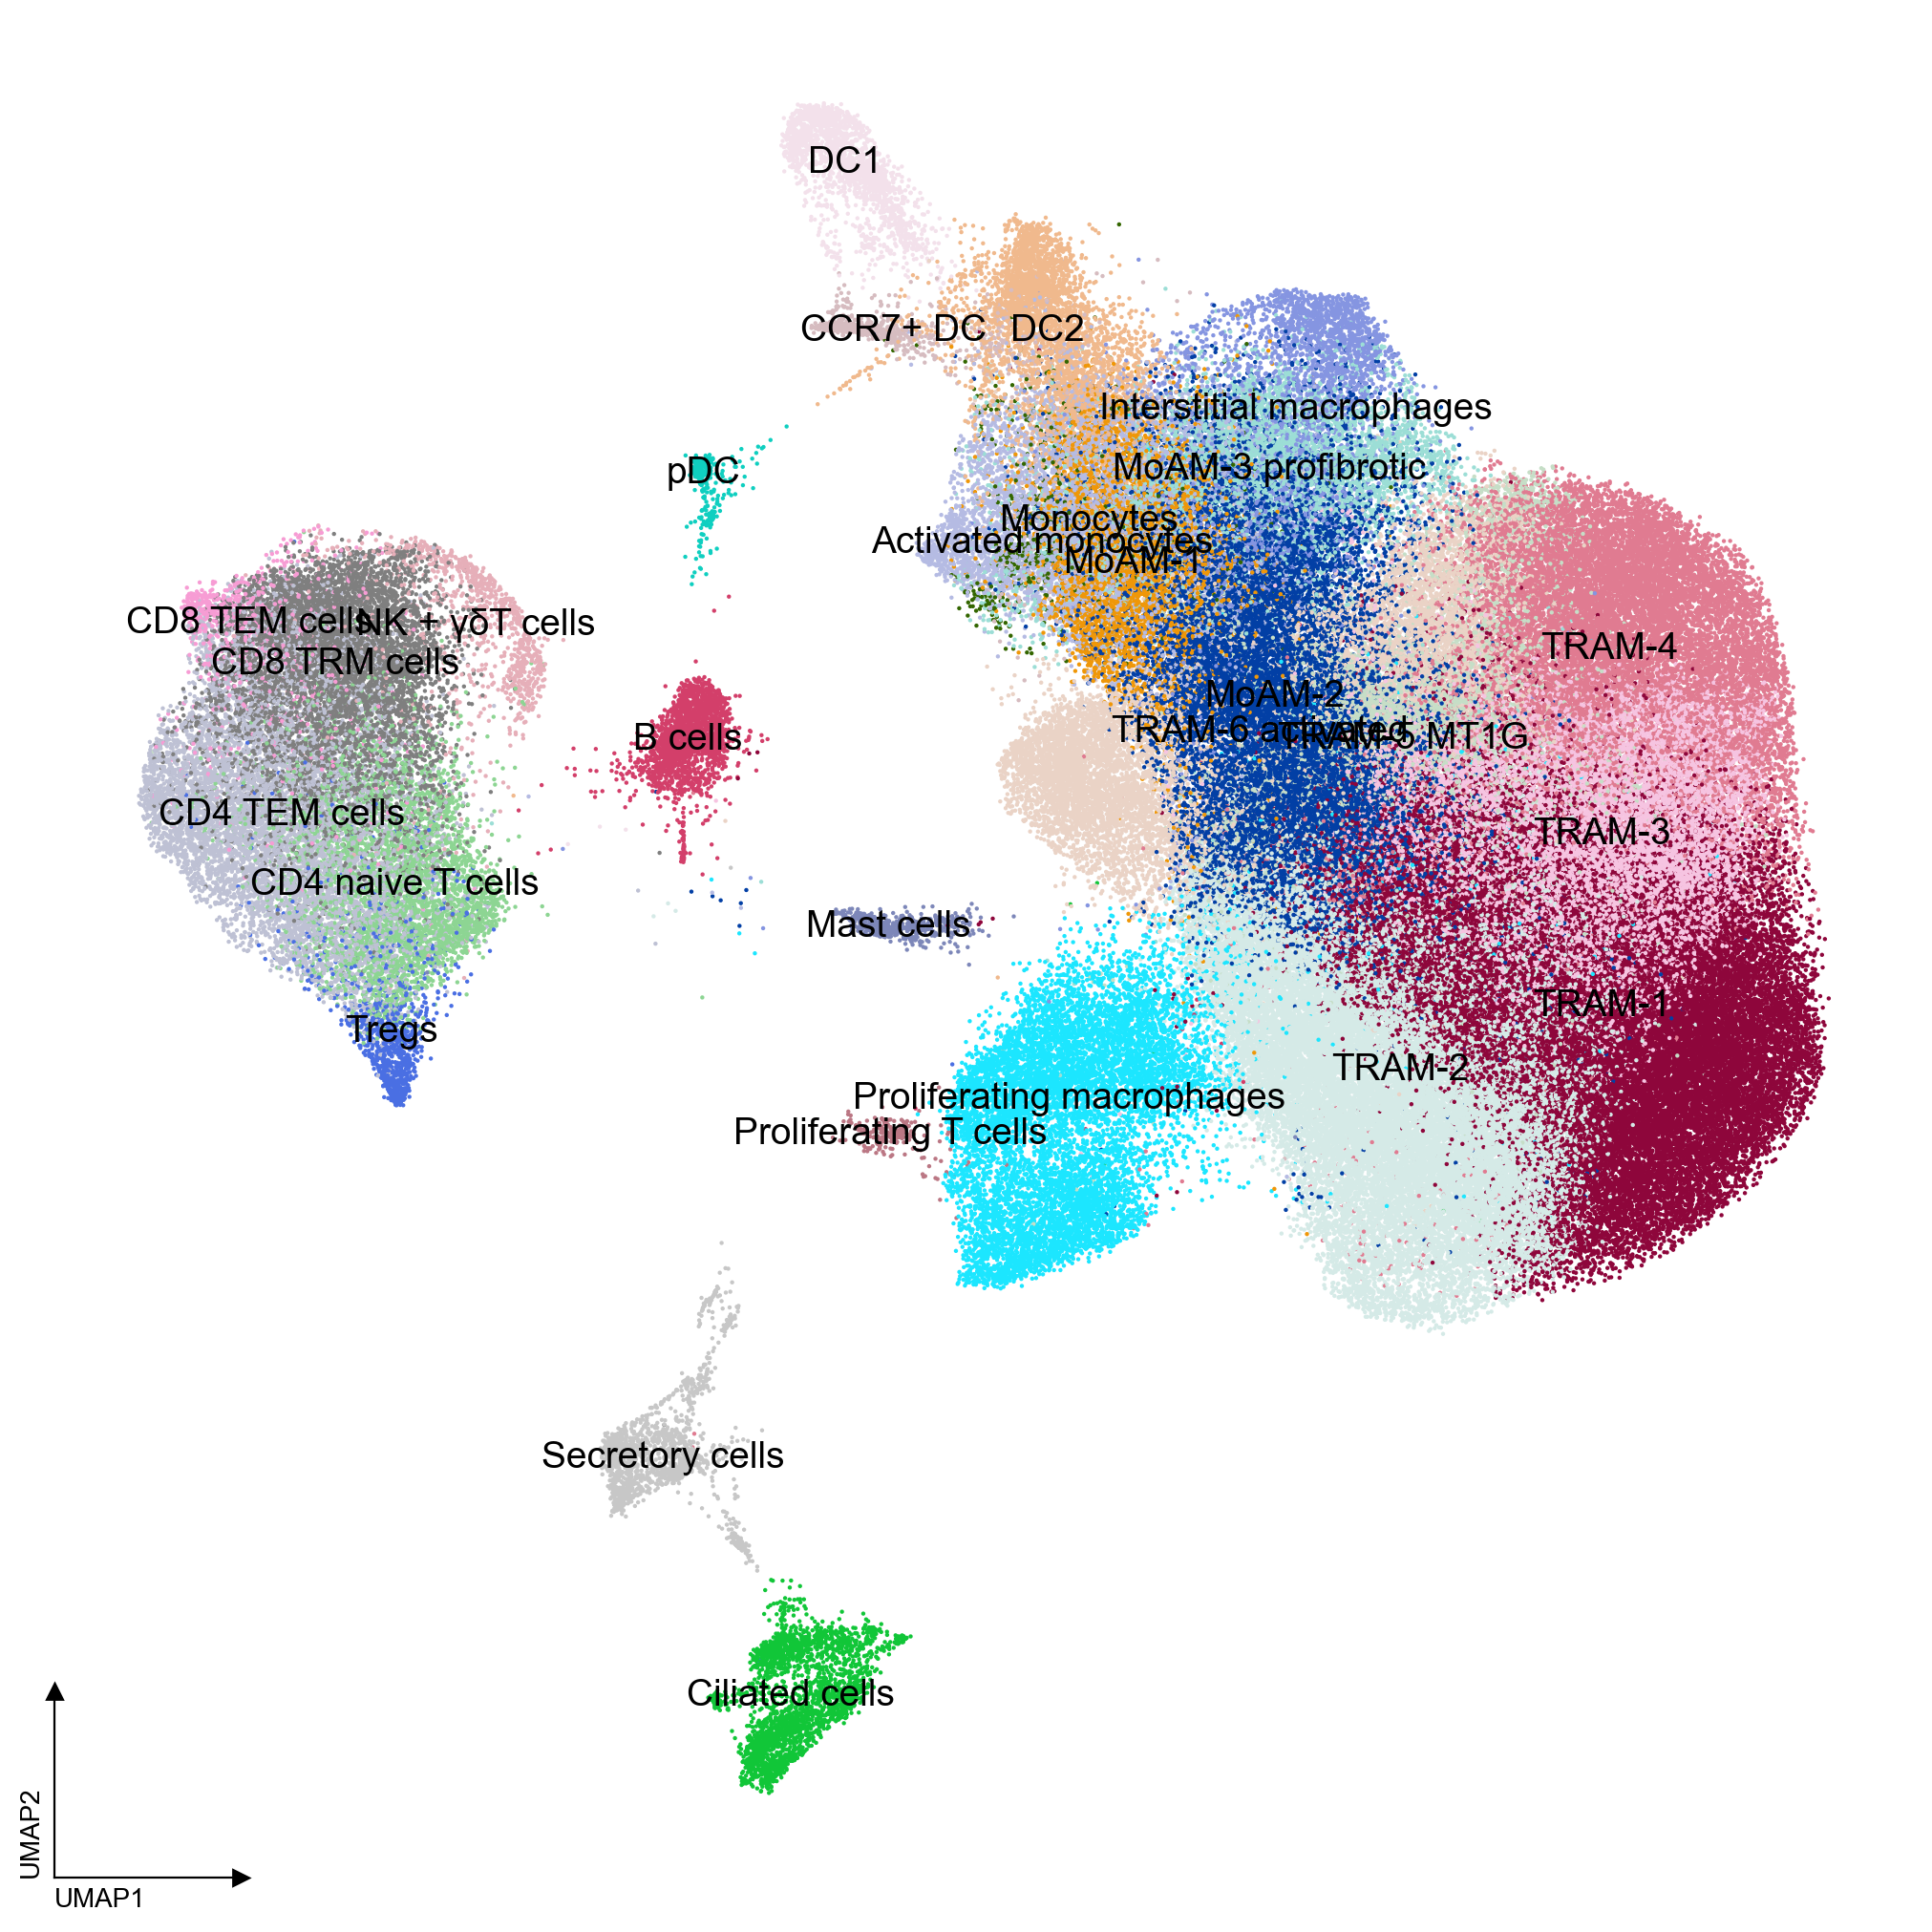

In [13]:
fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)
sc.pl.umap(
    adata,
    color='cell_type',
    legend_loc='on data',
    ax=ax,
    legend_fontweight='normal',
    legend_fontsize=14,
    title='',
    show=False,
    size=10
)
shrink_by = 0.1
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xbound = xlim[0] + (xlim[1] - xlim[0]) * shrink_by
ybound = ylim[0] + (ylim[1] - ylim[0]) * shrink_by

b = ax.spines["bottom"]
b.set_bounds(xlim[0], xbound)
ax.set_xlabel(ax.get_xlabel(), x=0, ha="left")
ax.plot(xbound, 0, ">k", transform=ax.get_xaxis_transform(), clip_on=False)

b = ax.spines["left"]
b.set_bounds(ylim[0], ybound)
ax.set_ylabel(ax.get_ylabel(), y=0, ha="left")
ax.plot(0, ybound, "^k", transform=ax.get_yaxis_transform(), clip_on=False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.collections[0].set_rasterized(True)

In [14]:
macs = adata[adata.obs.cell_type.eq('Proliferating macrophages')].copy()

In [15]:
macs

AnnData object with n_obs × n_vars = 9663 × 1000
    obs: 'Study', 'Sample', 'Sample ID', 'External Sample ID', 'Status', 'Patient', 'Age', 'Sex', 'Smoking status', 'Race', 'BMI', 'Type', 'Tissue location', 'Additional data', 'Chemistry', 'Protocol', 'Fastq', 'Genome build', 'Directory', 'Doublet threshold', 'batch', 'n_counts', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'cell_type'
    var: 'feature_types', 'n_counts', 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi', 'cell_type_colors', 'hvg', 'leiden', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

How many cells?

In [16]:
macs.obs.groupby(['External Sample ID', 'Status'], observed=True).size().reset_index(name='n_cells')

External Sample ID   Status  n_cells
0             Duke_C1  Control       44
1             Duke_C2  Control      362
2             Duke_C3  Control      159
3             Duke_C4  Control      448
4             Duke_C5  Control      335
5             Duke_C6  Control       52
6             Duke_C7  Control      114
7             Duke_C8  Control      317
8              SSc_C1  Control      153
9              SSc_C2  Control      276
10             SSc_C3  Control      300
11             SSc_C5  Control      198
12            SSc_C11  Control      102
13           SSc_SSc4  SSc-ILD      352
14           SSc_SSc6  SSc-ILD      870
15           SSc_SSc7  SSc-ILD     2243
16           SSc_SSc8  SSc-ILD      428
17           SSc_SSc9  SSc-ILD      148
18          SSc_SSc10  SSc-ILD      525
19          SSc_SSc12  SSc-ILD      579
20          SSc_SSc13  SSc-ILD      834
21          SSc_SSc14  SSc-ILD      369
22          SSc_SSc15  SSc-ILD      455

## 1. Naive approach: recluster the scVI latent

In [17]:
sc.pp.neighbors(macs, use_rep='X_scVI')

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/projects/b1038/Pulmonary/nmar

In [18]:
sc.tl.leiden(macs, resolution=0.5)

In [19]:
sc.tl.umap(macs)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


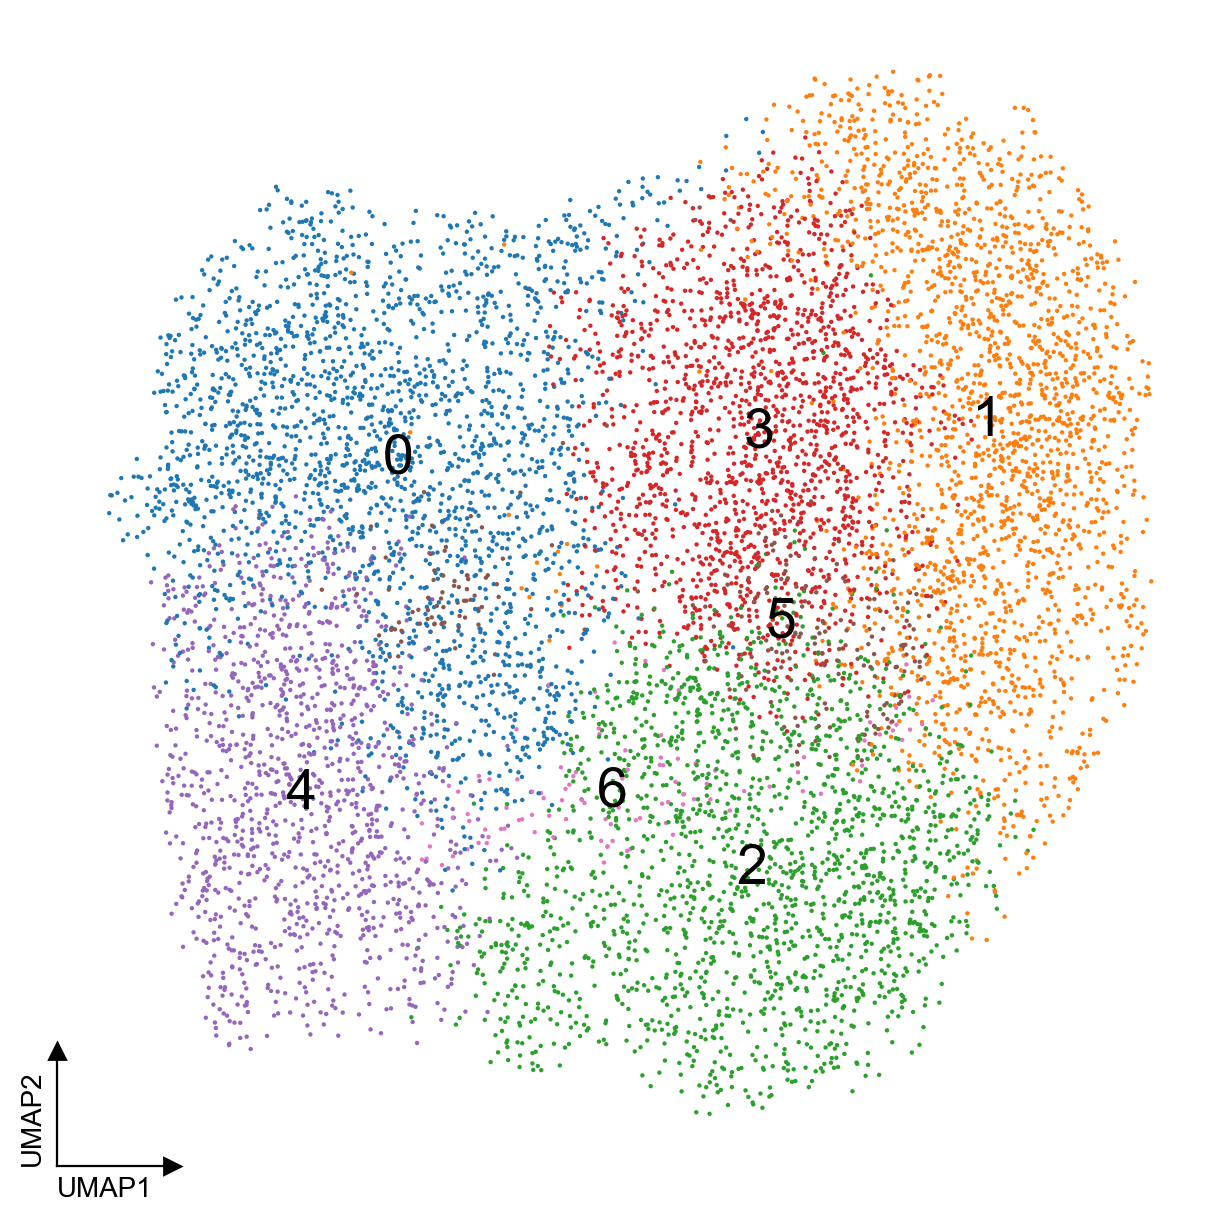

In [20]:
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
sc.pl.umap(
    macs,
    color='leiden',
    legend_loc='on data',
    ax=ax,
    legend_fontweight='normal',
    legend_fontsize=20,
    title='',
    show=False,
    size=10
)
shrink_by = 0.1
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xbound = xlim[0] + (xlim[1] - xlim[0]) * shrink_by
ybound = ylim[0] + (ylim[1] - ylim[0]) * shrink_by

b = ax.spines["bottom"]
b.set_bounds(xlim[0], xbound)
ax.set_xlabel(ax.get_xlabel(), x=0, ha="left")
ax.plot(xbound, 0, ">k", transform=ax.get_xaxis_transform(), clip_on=False)

b = ax.spines["left"]
b.set_bounds(ylim[0], ybound)
ax.set_ylabel(ax.get_ylabel(), y=0, ha="left")
ax.plot(0, ybound, "^k", transform=ax.get_yaxis_transform(), clip_on=False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.collections[0].set_rasterized(True)

Let's see how they clustered through pseudobulk marker heatmaps

In [21]:
THRESHOLD = 25
pseudobulk = []
meta = []
for sample in macs.obs['External Sample ID'].unique():
    for ct in macs.obs.leiden.unique():
        idx = macs.obs['External Sample ID'].eq(sample) & macs.obs.leiden.eq(ct)
        if idx.sum() < THRESHOLD:
            continue
        pseudobulk.append(macs.raw.X[idx].mean(axis=0).A1)
        meta.append((sample, ct))
pseudobulk = pd.DataFrame(
    pseudobulk,
    columns=macs.raw.var_names
)
meta = pd.DataFrame(meta, columns=('sample', 'cell_type'))

In [22]:
pseudobulk = ((pseudobulk - pseudobulk.mean(axis=0)) / pseudobulk.std(axis=0))

In [23]:
sample_to_status = adata.obs[
    ['External Sample ID', 'Status']
].drop_duplicates().set_index('External Sample ID').Status

In [24]:
meta['Status'] = sample_to_status[meta['sample']].values
meta.Status = pd.Categorical(meta.Status, ['Control', 'SSc-ILD'])
meta.cell_type = pd.Categorical(meta.cell_type)

In [25]:
meta = meta.sort_values(['cell_type', 'Status'])

In [26]:
# cell_type_colors = []
# for ct in meta.cell_type.cat.categories:
#     ct_idx = adata.obs.cell_type.cat.categories.get_loc(ct)
#     cell_type_colors.append(adata.uns['cell_type_colors'][ct_idx])

In [27]:
col_colors_df = get_color_annotations(meta, {
    # 'sample': 'tab20',
    'cell_type': 'tab10',
    'Status': ['royalblue', 'firebrick'],
})

These are the same markers for macrophage subtypes we used in Figure 1C

In [28]:
genes_to_plot = [
    'CLEC5A',
    'S100A12',
    'SPHK1',
    'PID1',
    'FCN1',
    'CD93',
    'CD300E',
    'EMP1',
    'CCL2',
    'VEGFA',
    'CYBB',
    'CCR2',
    'VCAN',
    'CRIP2',
    'CST6',
    'FCGR2B',
    'ENHO',
    'CDA',
    'FABP4',
    'PPARG',
    'MCEMP1',
    'S100A9',
    'C1QA',
    'APOE',
    'ITIH5',
    'PLAC8',
    'MARCO',
    'S100A8',
    'RETN',
    'PCOLCE2',
    'FBP1',
    'SDS',
    'CCL3',
    'SDC2',
    'PLA2G7',
    'SPP1',
    'MATK',
    'SEPP1',
    'LILRB5',
    'F13A1',
    'MERTK',
    'STAB1',
    'RNASE1',
    'SLC40A1',
    'GAL3ST4',
    'CCL13'
]

In [29]:
plot_df = pseudobulk.T.loc[genes_to_plot, meta.index]
max_sort = np.argsort(np.argmax(plot_df.values, axis=1))
plot_df = plot_df.iloc[max_sort, :]

In [30]:
plot_df = plot_df.loc[genes_to_plot]

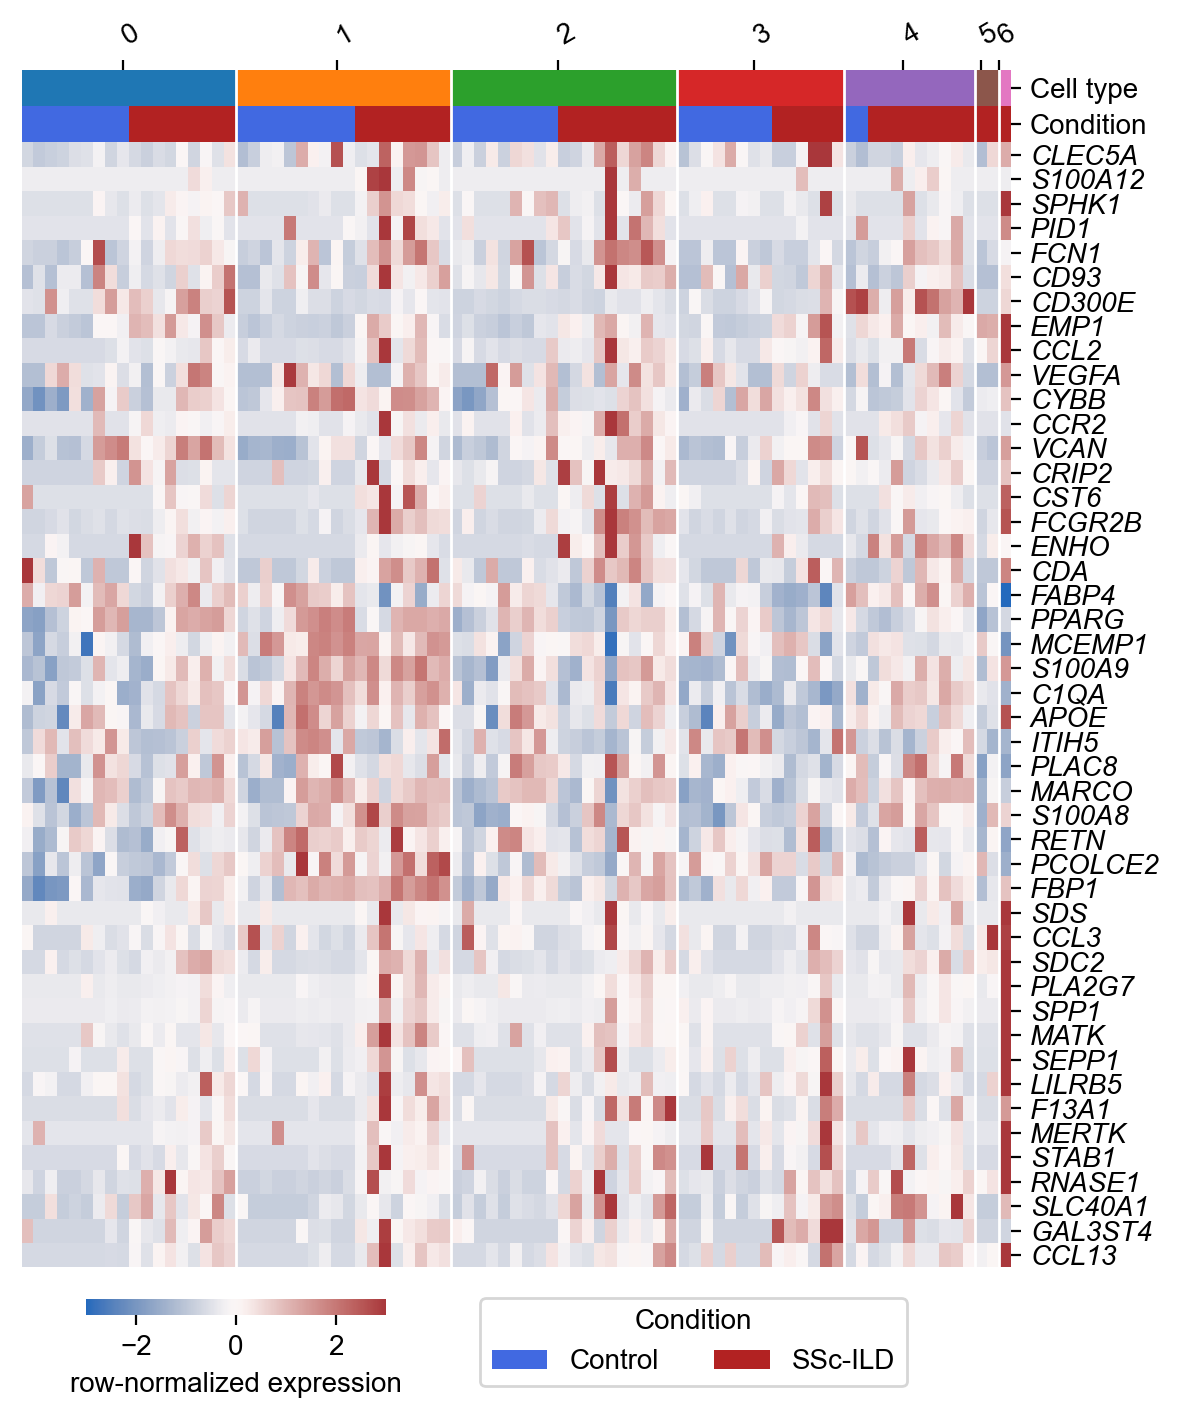

In [31]:
cg = sns.clustermap(
    plot_df,
    col_colors=col_colors_df,
    col_cluster=False,
    row_cluster=False,
    figsize=(6, 8),
    cmap='vlag',
    center=0,
    vmin=-3,
    vmax=3,
    dendrogram_ratio=0.001,
    colors_ratio=0.03,
    cbar_kws=dict(
        label='row-normalized expression',
        orientation='horizontal'
    ),
    xticklabels=[],
    yticklabels=plot_df.index,
)

cg.ax_col_colors.set_xticks(
    meta.reset_index(drop=True).reset_index().groupby('cell_type').index.mean()
)

cg.ax_col_colors.set_xticklabels(
    meta.cell_type.cat.categories,
)

cg.ax_col_colors.set_yticklabels(['Cell type', 'Condition'])
cg.ax_col_colors.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True, rotation=30)
trans = mpl.transforms.Affine2D().translate(-5, 0)
for t in cg.ax_col_colors.get_xticklabels():
    t.set_ha('left')
    t.set_transform(t.get_transform() + trans)
cg.ax_heatmap.legend(
    handles=[
        mpl.patches.Patch(fc='royalblue', label='Control'),
        mpl.patches.Patch(fc='firebrick', label='SSc-ILD'),
    ],
    loc='upper left',
    bbox_to_anchor=(0.45, -0.015),
    title='Condition',
    ncol=2
)

for ct in meta.cell_type.unique()[1:]:
    ct_loc = meta.index.get_loc(meta.index[meta.cell_type.eq(ct)][0])
    cg.ax_heatmap.axvline(ct_loc, color='w', lw=1)
    cg.ax_col_colors.axvline(ct_loc, color='w', lw=1)

cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), fontstyle='italic')
cg.ax_heatmap.tick_params(labelsize=10)

cg.fig.subplots_adjust(bottom=0.1, top=0.85)

cg.ax_cbar.set_position((0.08, 0.07, 0.25, 0.01))
cg.ax_cbar.set_xlabel(cg.ax_cbar.get_xlabel(), fontsize=10)

cg.ax_col_colors.collections[0].set_rasterized(True)
cg.ax_heatmap.collections[0].set_rasterized(True)

# cg.ax_col_dendrogram.figure.savefig('00_figures/Figure_2C_mac_markers.pdf', dpi=300)

This does not look like they clustered by our macrophage subtypes

Load cell cycle genes from Tirosh et al., 2015, according to [scanpy tutorial](https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb)

In [32]:
cell_cycle_genes = [x.strip() for x in open('./regev_lab_cell_cycle_genes.txt')]

In [33]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

In [34]:
cell_cycle_genes = pd.Series(cell_cycle_genes)
cell_cycle_genes = cell_cycle_genes[cell_cycle_genes.isin(macs.raw.var_names)]

In [35]:
plot_df = pseudobulk.T.loc[cell_cycle_genes, meta.index]
max_sort = np.argsort(np.argmax(plot_df.values, axis=1))
plot_df = plot_df.iloc[max_sort, :]

In [36]:
plot_df = plot_df.loc[cell_cycle_genes]

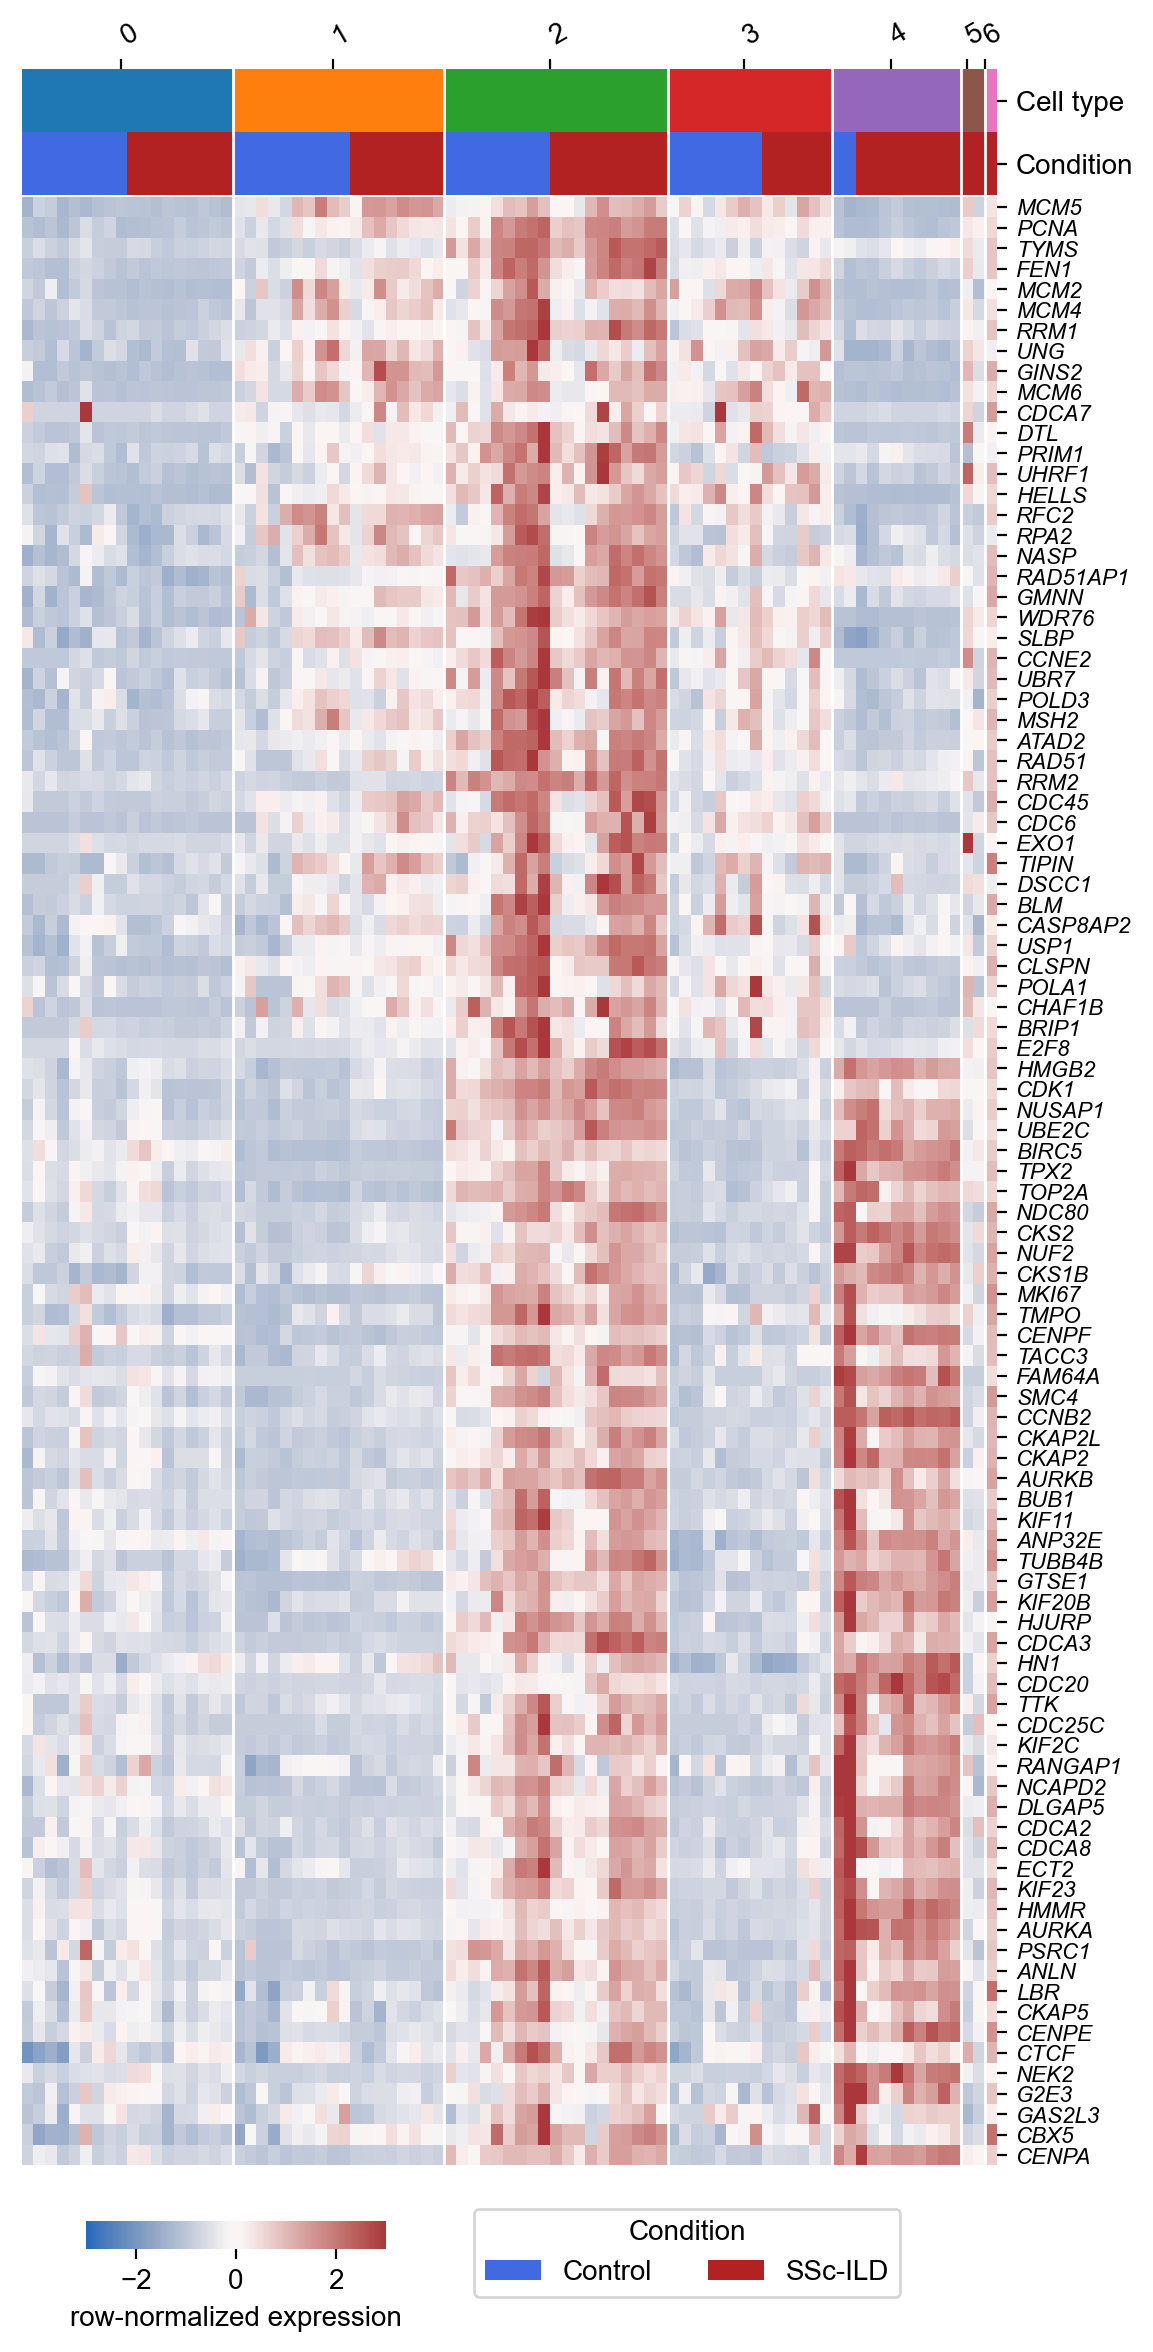

In [37]:
cg = sns.clustermap(
    plot_df,
    col_colors=col_colors_df,
    col_cluster=False,
    row_cluster=False,
    figsize=(6, 14),
    cmap='vlag',
    center=0,
    vmin=-3,
    vmax=3,
    dendrogram_ratio=0.001,
    colors_ratio=0.03,
    cbar_kws=dict(
        label='row-normalized expression',
        orientation='horizontal'
    ),
    xticklabels=[],
    yticklabels=plot_df.index,
)

cg.ax_col_colors.set_xticks(
    meta.reset_index(drop=True).reset_index().groupby('cell_type').index.mean()
)

cg.ax_col_colors.set_xticklabels(
    meta.cell_type.cat.categories,
)

cg.ax_col_colors.set_yticklabels(['Cell type', 'Condition'])
cg.ax_col_colors.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True, rotation=30)
trans = mpl.transforms.Affine2D().translate(-5, 0)
for t in cg.ax_col_colors.get_xticklabels():
    t.set_ha('left')
    t.set_transform(t.get_transform() + trans)
cg.ax_heatmap.legend(
    handles=[
        mpl.patches.Patch(fc='royalblue', label='Control'),
        mpl.patches.Patch(fc='firebrick', label='SSc-ILD'),
    ],
    loc='upper left',
    bbox_to_anchor=(0.45, -0.015),
    title='Condition',
    ncol=2
)

for ct in meta.cell_type.unique()[1:]:
    ct_loc = meta.index.get_loc(meta.index[meta.cell_type.eq(ct)][0])
    cg.ax_heatmap.axvline(ct_loc, color='w', lw=1)
    cg.ax_col_colors.axvline(ct_loc, color='w', lw=1)

cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), fontstyle='italic')
cg.ax_heatmap.tick_params(labelsize=8)

cg.fig.subplots_adjust(bottom=0.1, top=0.85)

cg.ax_cbar.set_position((0.08, 0.07, 0.25, 0.01))
cg.ax_cbar.set_xlabel(cg.ax_cbar.get_xlabel(), fontsize=10)

cg.ax_col_colors.collections[0].set_rasterized(True)
cg.ax_heatmap.collections[0].set_rasterized(True)

# cg.ax_col_dendrogram.figure.savefig('00_figures/Figure_2C_mac_markers.pdf', dpi=300)

This looks like clustering on cell cycle genes.

## 2. Less naive approach: new scVI

In [38]:
adata_raw = sc.read_h5ad('../../data/31_bal-object/raw_object.h5ad')

In [39]:
adata_raw.shape

(227967, 25538)

In [40]:
adata_raw.obs_names = (
    adata_raw.obs['External Sample ID'].astype(str)
    + '_'
    + adata_raw.obs_names.str.replace('-1-\d+$', '', regex=True)
)

In [41]:
macs_raw = adata_raw[macs.obs_names].copy()

In [42]:
macs_raw.shape

(9663, 25538)

Remove cell cycle genes

In [43]:
cell_cycle_genes = [x.strip() for x in open('./regev_lab_cell_cycle_genes.txt')]

In [44]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

In [45]:
cell_cycle_genes = pd.Series(cell_cycle_genes)
cell_cycle_genes = cell_cycle_genes[cell_cycle_genes.isin(macs_raw.var_names)]

In [46]:
macs_raw = macs_raw[:, ~macs_raw.var_names.isin(cell_cycle_genes)]

In [47]:
macs_raw.shape

(9663, 25442)

In [48]:
sc.pp.normalize_total(macs_raw, target_sum=1e4)
sc.pp.log1p(macs_raw)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [49]:
macs_raw.raw = macs_raw

In [50]:
sc.pp.highly_variable_genes(
    macs_raw,
    layer="counts",
    flavor="seurat_v3",
    n_top_genes=1000,
    subset=True,
    batch_key="Patient",
    span=0.5
)

In [51]:
scvi.model.SCVI.setup_anndata(
    macs_raw,
    layer="counts",
    batch_key="Patient",
    categorical_covariate_keys=["Chemistry"]
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [52]:
model = scvi.model.SCVI(macs_raw, n_layers=2, dropout_rate=0.2, n_latent=10)

In [53]:
model.train(
    max_epochs=400,
    use_gpu=True,
    check_val_every_n_epoch=2,
    early_stopping=True
)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/torch/cuda/__init__.py:155: UserWarning: 
NVIDIA H100 80GB HBM3 with CUDA capability sm_90 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70 sm_75 sm_80 sm_86.
If you want to use the NVIDIA H100 80GB HBM3 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU avail

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
model.save('03e_proliferating_macs.model')

In [53]:
model = model.load('03e_proliferating_macs.model', adata=macs_raw)

INFO     File 03e_proliferating_macs.model/model.pt already downloaded                                             


In [54]:
macs_raw.obsm["X_scVI"] = model.get_latent_representation()

In [55]:
sc.pp.neighbors(macs_raw, use_rep="X_scVI")

In [56]:
sc.tl.leiden(macs_raw, resolution=0.5)

In [57]:
sc.tl.umap(macs_raw)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


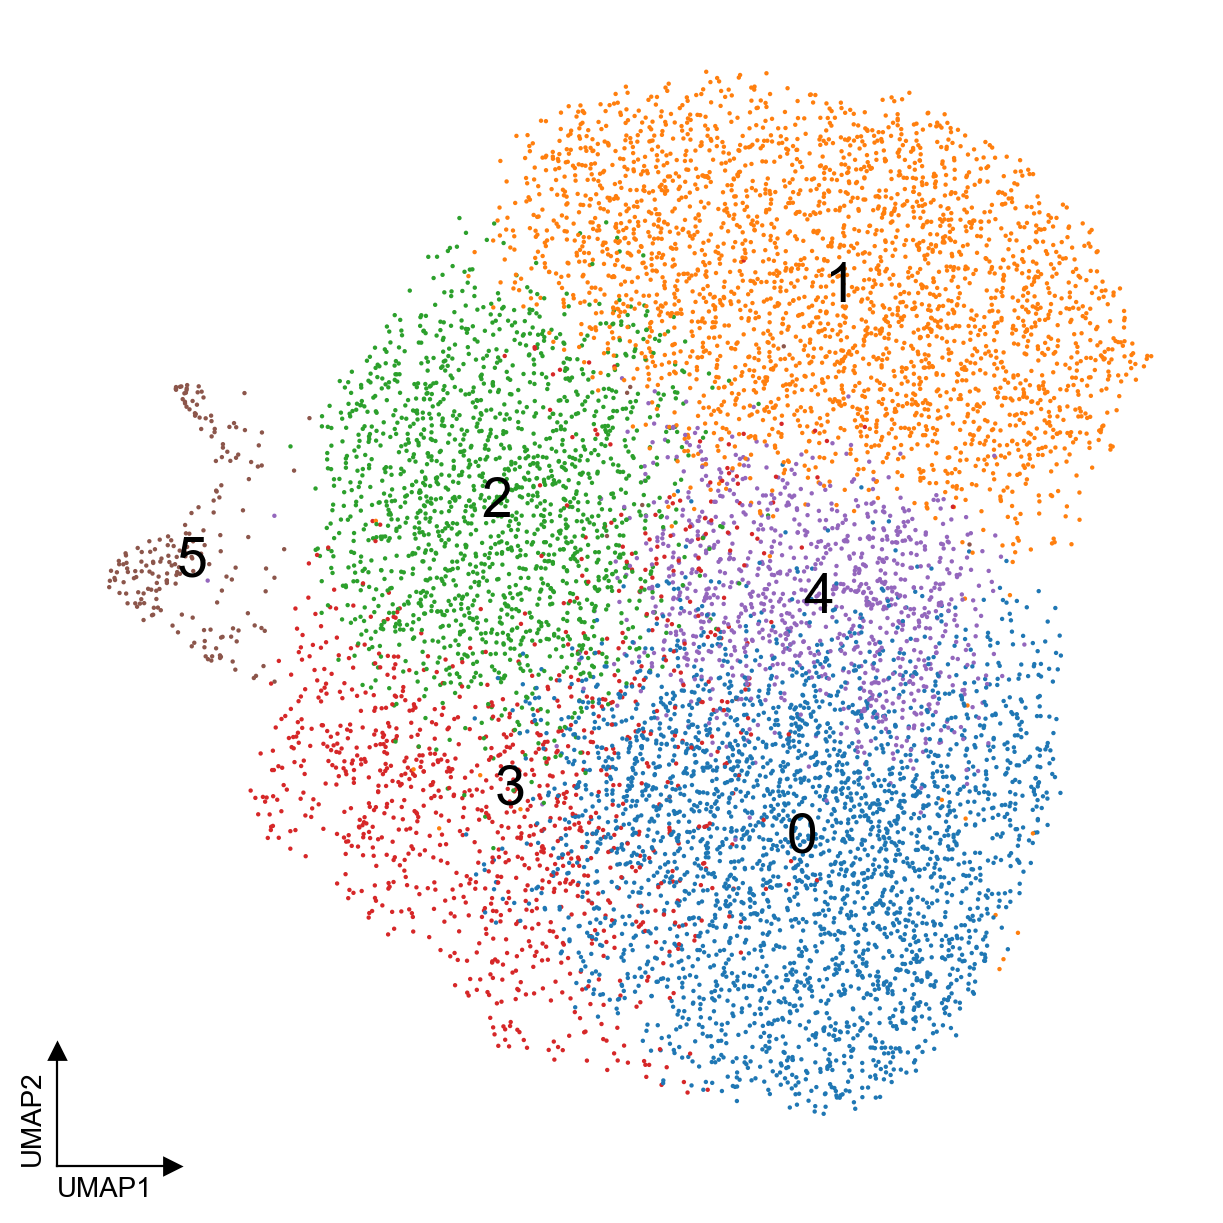

In [58]:
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
sc.pl.umap(
    macs_raw,
    color='leiden',
    legend_loc='on data',
    ax=ax,
    legend_fontweight='normal',
    legend_fontsize=20,
    title='',
    show=False,
    size=10
)
shrink_by = 0.1
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xbound = xlim[0] + (xlim[1] - xlim[0]) * shrink_by
ybound = ylim[0] + (ylim[1] - ylim[0]) * shrink_by

b = ax.spines["bottom"]
b.set_bounds(xlim[0], xbound)
ax.set_xlabel(ax.get_xlabel(), x=0, ha="left")
ax.plot(xbound, 0, ">k", transform=ax.get_xaxis_transform(), clip_on=False)

b = ax.spines["left"]
b.set_bounds(ylim[0], ybound)
ax.set_ylabel(ax.get_ylabel(), y=0, ha="left")
ax.plot(0, ybound, "^k", transform=ax.get_yaxis_transform(), clip_on=False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.collections[0].set_rasterized(True)

In [59]:
macs_raw.obs.leiden.value_counts()

leiden
0    2964
1    2750
2    1672
3    1075
4     996
5     206
Name: count, dtype: int64

In [60]:
THRESHOLD = 25
pseudobulk = []
meta = []
for sample in macs_raw.obs['External Sample ID'].unique():
    for ct in macs_raw.obs.leiden.unique():
        idx = macs_raw.obs['External Sample ID'].eq(sample) & macs_raw.obs.leiden.eq(ct)
        if idx.sum() < THRESHOLD:
            continue
        pseudobulk.append(macs_raw.raw.X[idx].mean(axis=0).A1)
        meta.append((sample, ct))
pseudobulk = pd.DataFrame(
    pseudobulk,
    columns=macs_raw.raw.var_names
)
meta = pd.DataFrame(meta, columns=('sample', 'cell_type'))

In [61]:
pseudobulk = ((pseudobulk - pseudobulk.mean(axis=0)) / pseudobulk.std(axis=0))

In [62]:
sample_to_status = adata.obs[
    ['External Sample ID', 'Status']
].drop_duplicates().set_index('External Sample ID').Status

In [63]:
meta['Status'] = sample_to_status[meta['sample']].values
meta.Status = pd.Categorical(meta.Status, ['Control', 'SSc-ILD'])
meta.cell_type = pd.Categorical(meta.cell_type)

In [64]:
meta = meta.sort_values(['cell_type', 'Status'])

In [65]:
col_colors_df = get_color_annotations(meta, {
    # 'sample': 'tab20',
    'cell_type': 'tab10',
    'Status': ['royalblue', 'firebrick'],
})

These are the same markers for macrophage subtypes we used in Figure 1C

In [88]:
genes_to_plot = [
    'CLEC5A',
    'S100A12',
    'SPHK1',
    'PID1',
    'FCN1',
    'CD93',
    'CD300E',
    'EMP1',
    'CCL2',
    'VEGFA',
    'CYBB',
    'CCR2',
    'VCAN',
    'CRIP2',
    'CST6',
    'FCGR2B',
    'ENHO',
    'CDA',
    'FABP4',
    'PPARG',
    'MCEMP1',
    'S100A9',
    'C1QA',
    'APOE',
    'ITIH5',
    'PLAC8',
    'MARCO',
    'S100A8',
    'RETN',
    'PCOLCE2',
    'FBP1',
    'SDS',
    'CCL3',
    'SDC2',
    'PLA2G7',
    'SPP1',
    'MATK',
    'SEPP1',
    'LILRB5',
    'F13A1',
    'MERTK',
    'STAB1',
    'RNASE1',
    'SLC40A1',
    'GAL3ST4',
    'CCL13',
    'IGF1',
    'COL14A1',
]

In [89]:
plot_df = pseudobulk.T.loc[genes_to_plot, meta.index]
max_sort = np.argsort(np.argmax(plot_df.values, axis=1))
plot_df = plot_df.iloc[max_sort, :]

In [90]:
plot_df = plot_df.loc[genes_to_plot]

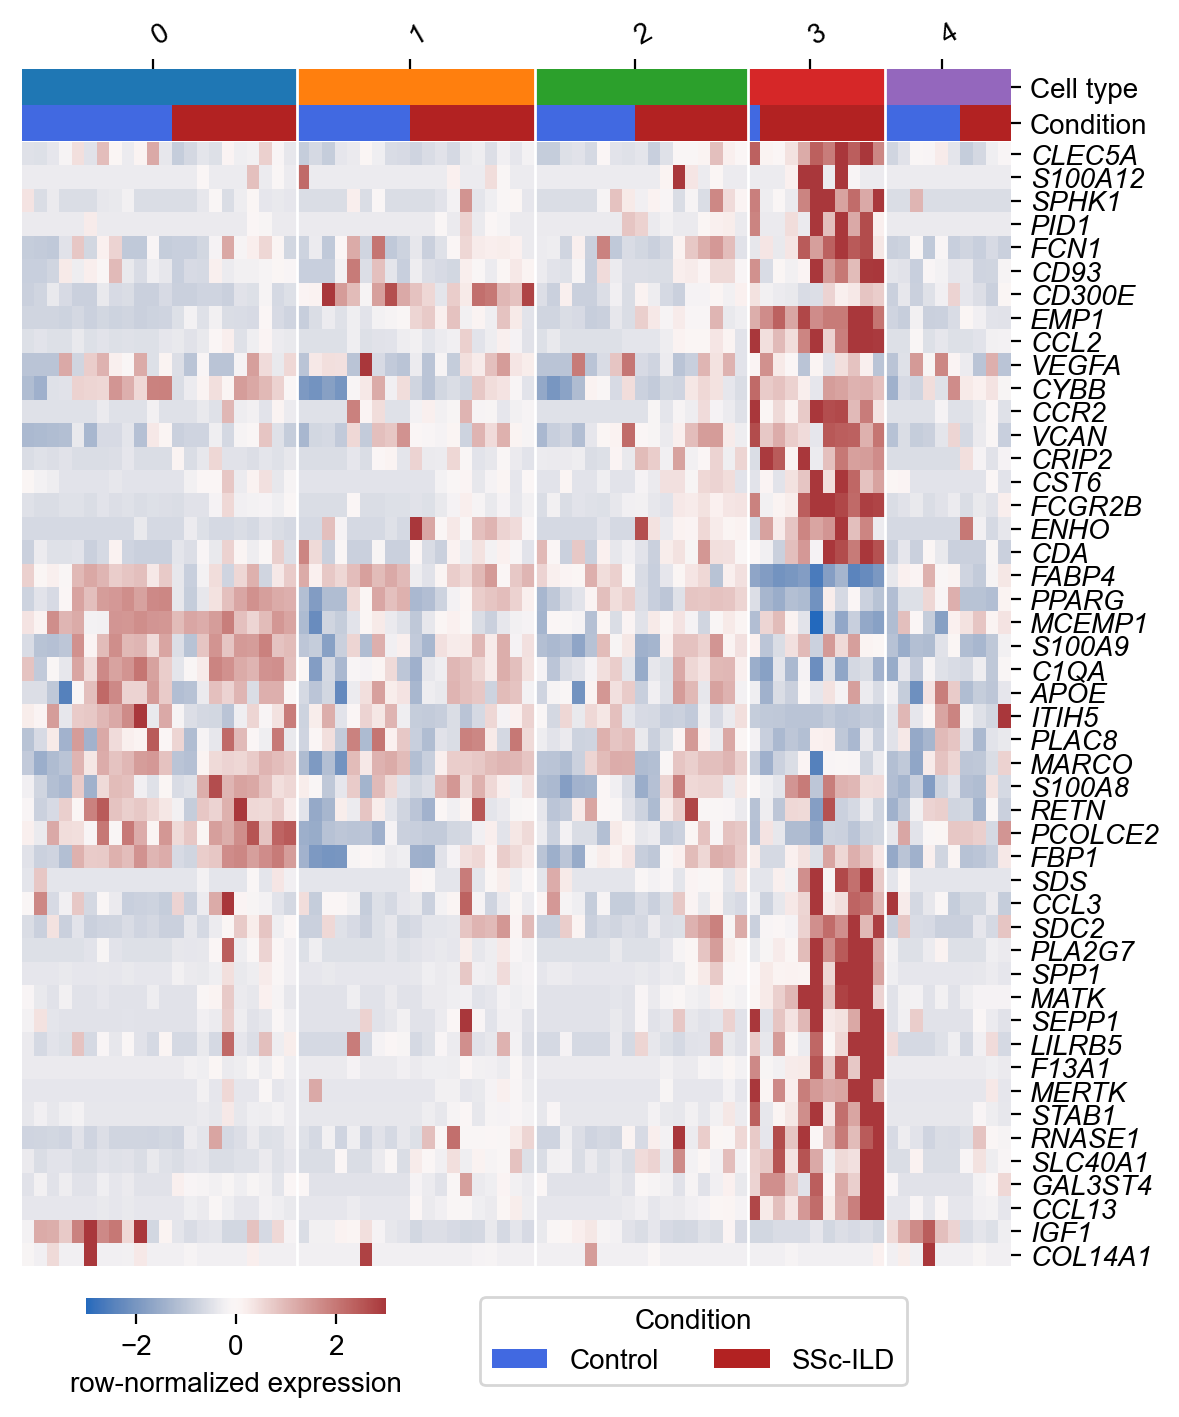

In [91]:
cg = sns.clustermap(
    plot_df,
    col_colors=col_colors_df,
    col_cluster=False,
    row_cluster=False,
    figsize=(6, 8),
    cmap='vlag',
    center=0,
    vmin=-3,
    vmax=3,
    dendrogram_ratio=0.001,
    colors_ratio=0.03,
    cbar_kws=dict(
        label='row-normalized expression',
        orientation='horizontal'
    ),
    xticklabels=[],
    yticklabels=plot_df.index,
)

cg.ax_col_colors.set_xticks(
    meta.reset_index(drop=True).reset_index().groupby('cell_type').index.mean()
)

cg.ax_col_colors.set_xticklabels(
    meta.cell_type.cat.categories,
)

cg.ax_col_colors.set_yticklabels(['Cell type', 'Condition'])
cg.ax_col_colors.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True, rotation=30)
trans = mpl.transforms.Affine2D().translate(-5, 0)
for t in cg.ax_col_colors.get_xticklabels():
    t.set_ha('left')
    t.set_transform(t.get_transform() + trans)
cg.ax_heatmap.legend(
    handles=[
        mpl.patches.Patch(fc='royalblue', label='Control'),
        mpl.patches.Patch(fc='firebrick', label='SSc-ILD'),
    ],
    loc='upper left',
    bbox_to_anchor=(0.45, -0.015),
    title='Condition',
    ncol=2
)

for ct in meta.cell_type.unique()[1:]:
    ct_loc = meta.index.get_loc(meta.index[meta.cell_type.eq(ct)][0])
    cg.ax_heatmap.axvline(ct_loc, color='w', lw=1)
    cg.ax_col_colors.axvline(ct_loc, color='w', lw=1)

cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), fontstyle='italic')
cg.ax_heatmap.tick_params(labelsize=10)

cg.fig.subplots_adjust(bottom=0.1, top=0.85)

cg.ax_cbar.set_position((0.08, 0.07, 0.25, 0.01))
cg.ax_cbar.set_xlabel(cg.ax_cbar.get_xlabel(), fontsize=10)

cg.ax_col_colors.collections[0].set_rasterized(True)
cg.ax_heatmap.collections[0].set_rasterized(True)

# cg.ax_col_dendrogram.figure.savefig('00_figures/Figure_2C_mac_markers.pdf', dpi=300)

In [92]:
sc.tl.rank_genes_groups(macs_raw, "leiden", method="t-test", n_genes=200)

In [93]:
def get_markers(
    anndata,
    groupby,
    key="rank_genes_groups",
    p_val_cutoff=0.05,
    logfc_cutoff=0.5
):
    markers = pd.concat([
        pd.DataFrame(anndata.uns[key]["names"]).melt(),
        pd.DataFrame(anndata.uns[key]["pvals_adj"]).melt(),
        pd.DataFrame(anndata.uns[key]["logfoldchanges"]).melt()
    ], axis=1)
    markers.columns = ("cluster", "gene", "cluster2", "p_val_adj", "cluster3", "avg_logFC")
    markers = markers.loc[:, ["cluster", "gene", "avg_logFC", "p_val_adj"]]
    markers = markers.loc[markers.avg_logFC > logfc_cutoff, ]
    markers = markers.loc[markers.p_val_adj < p_val_cutoff, ]

    for cluster in markers.cluster.unique():
        cells = anndata.obs[groupby] == cluster
        in_cluster_selector = markers.cluster == cluster
        genes = markers.gene[in_cluster_selector]
        in_cluster = np.sum(anndata.raw[cells, genes].X > 0, axis=0) / cells.sum()
        markers.loc[in_cluster_selector, "pct.1"] = in_cluster.A1
        other_cells = anndata.obs[groupby] != cluster
        other_clusters = np.sum(anndata.raw[other_cells, genes].X > 0, axis=0) / other_cells.sum()
        markers.loc[in_cluster_selector, "pct.2"] = other_clusters.A1

    # all_clusters = markers.cluster.unique()
    # if all_clusters.size == 1:
    #     all_clusters = list(anndata.obs[groupby].astype(str).unique())
    #     if "nan" in all_clusters:
    #         all_clusters.remove("nan")
    #     all_clusters = pd.Series(all_clusters)

    markers["p_val"] = markers.p_val_adj
    markers = markers.loc[:, ["p_val", "avg_logFC", "pct.1", "pct.2", "p_val_adj", "cluster", "gene"]]
    return markers

In [94]:
markers = get_markers(macs_raw, "leiden")

In [95]:
markers.cluster = markers.cluster.astype(int)

In [96]:
markers.sort_values(["cluster", "avg_logFC"], ascending=[True, False], inplace=True)

In [97]:
markers.groupby("cluster").head(10)

p_val  avg_logFC     pct.1     pct.2      p_val_adj  cluster  \
8     1.065967e-242   2.177693  0.593455  0.163607  1.065967e-242        0   
12    4.005376e-220   1.680533  0.721997  0.352441  4.005376e-220        0   
54    4.003248e-114   1.603064  0.467611  0.167637  4.003248e-114        0   
139    8.667567e-65   1.598885  0.305331  0.113599   8.667567e-65        0   
103    8.876273e-82   1.523227  0.390688  0.144350   8.876273e-82        0   
10    2.331156e-241   1.468562  0.827260  0.474548  2.331156e-241        0   
4     5.669052e-273   1.421928  0.886640  0.600985  5.669052e-273        0   
175    2.510707e-53   1.396439  0.299933  0.095387   2.510707e-53        0   
3     2.456151e-280   1.352497  0.845816  0.544559  2.456151e-280        0   
9     5.233306e-243   1.350512  0.846829  0.545604  5.233306e-243        0   
257    3.922639e-95   2.804969  0.250545  0.047881   3.922639e-95        1   
313    4.149998e-57   2.447545  0.172000  0.041082   4.149998e-57        1   
201    0.000000e+00   2.332393  0.810545  0.385072   0.000000e+00        1   
253   3.859251e-100   2.230652  0.317455  0.081730  3.859251e-100        1   
200    0.000000e+00   2.009833  0.999636  0.948214   0.000000e+00        1   
223   1.470980e-152   1.990861  0.472364  0.170114  1.470980e-152        1   
347    1.116427e-46   1.915938  0.179273  0.064661   1.116427e-46        1   
373    7.830824e-43   1.823838  0.172000  0.065963   7.830824e-43        1   
242   2.381925e-109   1.777808  0.417455  0.224939  2.381925e-109        1   
241   4.134590e-111   1.761436  0.428727  0.176624  4.134590e-111        1   
400    0.000000e+00   4.094386  0.974282  0.643098   0.000000e+00        2   
438   1.181243e-125   3.728831  0.411483  0.052559  1.181243e-125        2   
421   5.065714e-166   3.224016  0.527512  0.087473  5.065714e-166        2   
424   3.240791e-156   3.049515  0.542464  0.159805  3.240791e-156        2   
460    6.335366e-96   2.983035  0.393541  0.057940   6.335366e-96        2   
443   2.923459e-120   2.797111  0.486842  0.142035  2.923459e-120        2   
436   1.084908e-131   2.771926  0.481459  0.090852  1.084908e-131        2   
452   1.132570e-107   2.755251  0.433014  0.082718  1.132570e-107        2   
413   4.463062e-200   2.707173  0.641148  0.214116  4.463062e-200        2   
462    2.718965e-95   2.678654  0.404904  0.069954   2.718965e-95        2   
771    4.540537e-15   4.848743  0.086512  0.005007   4.540537e-15        3   
734    2.316993e-17   4.666016  0.101395  0.006986   2.316993e-17        3   
681    9.192472e-23   4.566441  0.130233  0.009315   9.192472e-23        3   
716    6.202002e-19   4.557768  0.113488  0.007452   6.202002e-19        3   
713    5.240088e-19   4.549823  0.112558  0.008267   5.240088e-19        3   
631    2.546197e-35   4.016315  0.199070  0.017000   2.546197e-35        3   
652    3.550415e-27   4.006517  0.177674  0.026083   3.550415e-27        3   
644    1.858662e-30   3.959342  0.213953  0.044364   1.858662e-30        3   
719    7.444293e-19   3.944828  0.118140  0.010363   7.444293e-19        3   
785    1.959409e-14   3.910357  0.083721  0.006870   1.959409e-14        3   
911    2.252817e-04   2.949655  0.027108  0.004269   2.252817e-04        4   
822    2.123993e-12   2.537140  0.101406  0.036345   2.123993e-12        4   
883    3.697138e-05   2.402999  0.037149  0.008884   3.697138e-05        4   
925    4.102270e-04   1.623787  0.048193  0.028730   4.102270e-04        4   
926    4.220247e-04   1.503291  0.052209  0.044421   4.220247e-04        4   
801    3.662339e-52   1.158882  0.733936  0.632860   3.662339e-52        4   
860    5.759920e-06   1.129614  0.105422  0.063459   5.759920e-06        4   
803    1.285738e-37   1.120244  0.617470  0.496942   1.285738e-37        4   
872    2.255891e-05   1.097141  0.100402  0.071766   2.255891e-05        4   
802    6.118735e-49   1.072961  0.776104  0.678551   6.118735e-49        4   
1176   2.400409e-02   4.814834  0.03

## Intermediate conclusions

Some clustering signal now comes from macrophage subtypes we see in non-proliferating cells (INHBA, SPP1, F13A1). However, the nature of first several clusters seems to be still related to cell cycle.

Possibly, we need to add cell cycle score to scVI covariate? Or just quantify cluster #5 right now

In [98]:
counts = macs_raw.obs.groupby(
    ["leiden", "Status", "External Sample ID"],
    observed=True
).size().reset_index(name='n_cells')

In [99]:
counts.leiden = counts.leiden.astype("category")
counts.Status = pd.Categorical(counts.Status.astype(str).replace({
    'control': 'Control',
    'SSc': 'SSc-ILD'
}), categories=['Control', 'SSc-ILD'])

In [100]:
count_per_sample = counts.groupby("External Sample ID").n_cells.sum()

In [101]:
counts["fraction_per_sample"] = (
    counts.n_cells
    / count_per_sample[counts["External Sample ID"]].values
)

In [102]:
counts["percent_in_sample"] = counts.fraction_per_sample * 100

In [103]:
stat_results = []
for ct in counts.leiden.unique():
    ctrl = counts.percent_in_sample[counts.leiden.eq(ct) & counts.Status.eq("Control")]
    ssc = counts.percent_in_sample[counts.leiden.eq(ct) & counts.Status.eq("SSc-ILD")]
    if ctrl.size == 0 or ssc.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(ctrl, ssc).pvalue
    stat_results.append(["leiden", ct, "Control", "SSc-ILD", ctrl.size, ssc.size, pval])
stat_results = pd.DataFrame(
    stat_results,
    columns=[
        "variable", "value", "group1", "group2",
        "group1_size", "group2_size", "pval"
    ]
)
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [104]:
stat_results_sign

variable value   group1   group2  group1_size  group2_size      pval  \
0   leiden     0  Control  SSc-ILD           13           10  0.000362   
1   leiden     1  Control  SSc-ILD           13           10  0.000907   
3   leiden     3  Control  SSc-ILD           13           10  0.000362   
5   leiden     5  Control  SSc-ILD           13            9  0.023141   

   pval_adj  
0  0.001087  
1  0.001814  
3  0.001087  
5  0.034712

Text(0.5, 18.167, 'Proliferating macrophage subclusters')

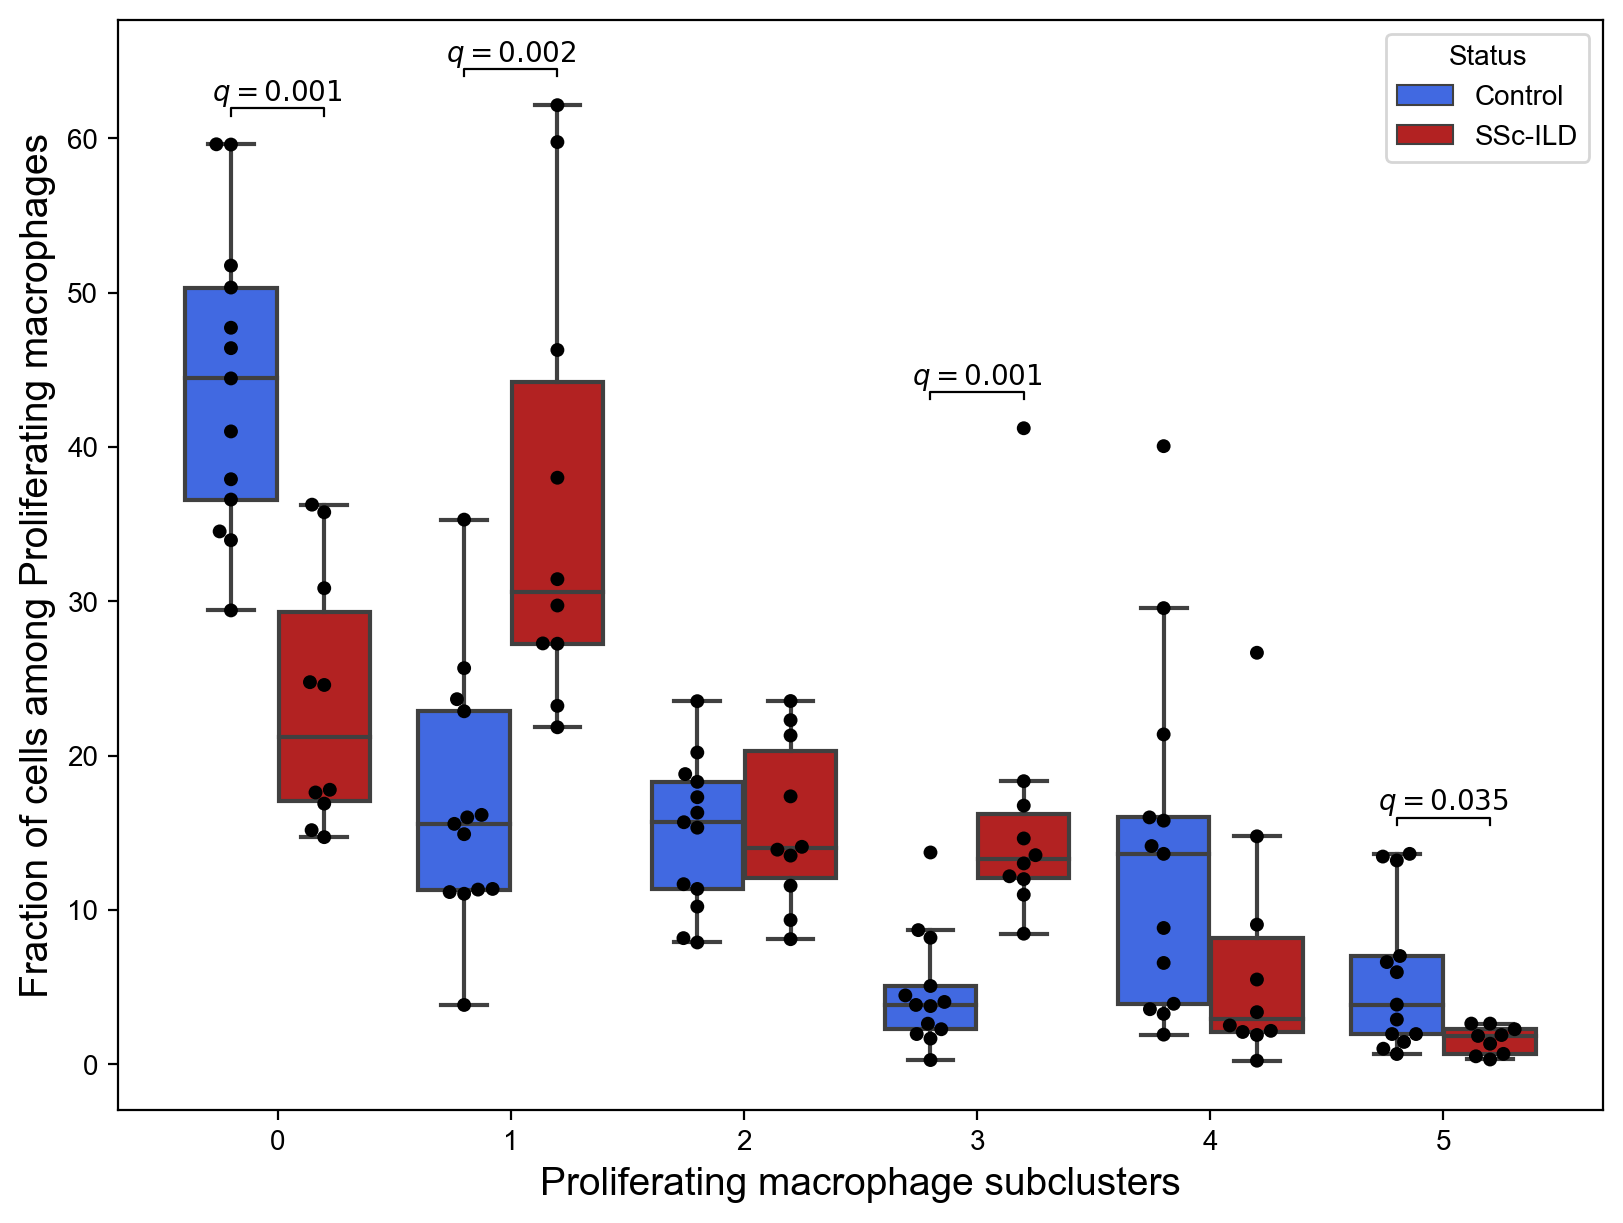

In [105]:
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
sns.boxplot(
    data=counts,
    x='leiden',
    y='percent_in_sample',
    hue='Status',
    palette=['royalblue', 'firebrick'],
    saturation=1,
    showfliers=False,
    # linecolor='k',
    ax=ax
)
sns.swarmplot(
    data=counts,
    x='leiden',
    y='percent_in_sample',
    hue='Status',
    dodge=True,
    palette=['k', 'k'],
    # jitter=0.2,
    legend=False,
    ax=ax
)

# Get the number of hue categories for proper positioning
n_hue_cats = len(counts.Status.unique())
width = 0.8  # default width of seaborn boxplot

# Get cell type labels and their positions
cell_types = counts.leiden.unique()
cell_type_positions = {ct: i for i, ct in enumerate(cell_types)}

# Get hue labels and map to their positions
hue_categories = sorted(counts.Status.unique())
hue_offsets = np.linspace(0, width - width / n_hue_cats, n_hue_cats) + width / (2 * n_hue_cats) - width / 2

start_height = counts.groupby('leiden')['percent_in_sample'].max().to_dict()
incrementer = 15 # px
q = ax.transData.inverted().transform([[0, 0], [0, incrementer]])
y_offset = q[1][1] - q[0][1]
gap = y_offset / 4

# Add annotations for significant comparisons
for _, r in stat_results_sign.iterrows():
    cell_type = r.value
    base_x = cell_type_positions[cell_type]
    base_y = start_height[cell_type]

    # Get the x positions for each hue level within this cell type
    hue1_idx = hue_categories.index(r.group1)
    hue2_idx = hue_categories.index(r.group2)
    x1 = base_x + hue_offsets[hue1_idx]
    x2 = base_x + hue_offsets[hue2_idx]

    # Format p-value
    p_text = f'$q={r.pval_adj:.3f}$'

    # Add bracket and annotation
    y = base_y + y_offset
    ax.plot([x1, x1, x2, x2], [y, y+gap, y+gap, y], lw=0.8, c='k')
    ax.text((x1+x2)/2, y+gap, p_text, ha='center', va='bottom', fontsize=10)

    # Increment height for next annotation if needed
    start_height[cell_type] += y_offset

ax.set_ylabel('Fraction of cells among Proliferating macrophages', size=14)
ax.set_xlabel('Proliferating macrophage subclusters', size=14)

### Merge clusters 0-1-2 and 4 as TRAMs

In [121]:
counts_merged = counts.copy()

In [122]:
# remove doublets
counts_merged = counts_merged.loc[counts_merged.leiden.ne('5')]

In [123]:
counts_merged.leiden = counts_merged.leiden.astype(int).replace({1: 0, 2: 0, 4: 0})

In [124]:
counts_merged = counts_merged.groupby(
    ['leiden', 'Status', 'External Sample ID'],
    observed=True
).sum().reset_index()

Verify

In [125]:
counts_merged.groupby('External Sample ID').fraction_per_sample.sum()

External Sample ID
Duke_C1      0.863636
Duke_C2      0.961326
Duke_C3      0.867925
Duke_C4      0.970982
Duke_C5      0.940299
Duke_C6      0.865385
Duke_C7      0.929825
Duke_C8      0.933754
SSc_C1       0.980392
SSc_C2       0.985507
SSc_C3       0.993333
SSc_C5       0.989899
SSc_C11      0.980392
SSc_SSc4     0.977273
SSc_SSc6     0.981609
SSc_SSc7     0.996879
SSc_SSc8     1.000000
SSc_SSc9     0.993243
SSc_SSc10    0.986667
SSc_SSc12    0.994819
SSc_SSc13    0.973621
SSc_SSc14    0.981030
SSc_SSc15    0.973626
Name: fraction_per_sample, dtype: float64

In [126]:
stat_results = []
for ct in counts_merged.leiden.unique():
    ctrl = counts_merged.percent_in_sample[counts_merged.leiden.eq(ct) & counts_merged.Status.eq("Control")]
    ssc = counts_merged.percent_in_sample[counts_merged.leiden.eq(ct) & counts_merged.Status.eq("SSc-ILD")]
    if ctrl.size == 0 or ssc.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(ctrl, ssc).pvalue
    stat_results.append(["leiden", ct, "Control", "SSc-ILD", ctrl.size, ssc.size, pval])
stat_results = pd.DataFrame(
    stat_results,
    columns=[
        "variable", "value", "group1", "group2",
        "group1_size", "group2_size", "pval"
    ]
)
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [127]:
stat_results_sign

variable  value   group1   group2  group1_size  group2_size      pval  \
1   leiden      3  Control  SSc-ILD           13           10  0.000362   

   pval_adj  
1  0.000725

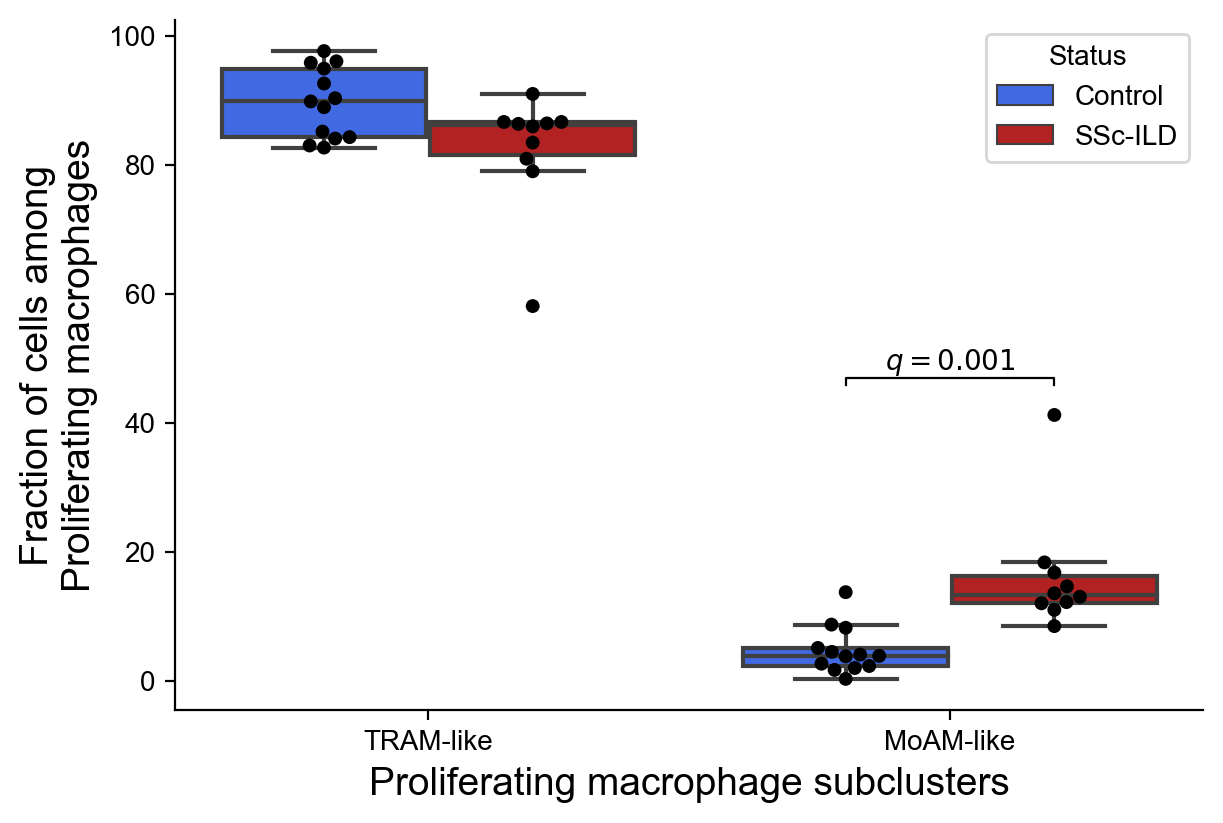

In [136]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
sns.boxplot(
    data=counts_merged,
    x='leiden',
    y='percent_in_sample',
    hue='Status',
    palette=['royalblue', 'firebrick'],
    saturation=1,
    showfliers=False,
    # linecolor='k',
    ax=ax
)
sns.swarmplot(
    data=counts_merged,
    x='leiden',
    y='percent_in_sample',
    hue='Status',
    dodge=True,
    palette=['k', 'k'],
    # jitter=0.2,
    legend=False,
    ax=ax
)

# Get the number of hue categories for proper positioning
n_hue_cats = len(counts_merged.Status.unique())
width = 0.8  # default width of seaborn boxplot

# Get cell type labels and their positions
cell_types = counts_merged.leiden.unique()
cell_type_positions = {ct: i for i, ct in enumerate(cell_types)}

# Get hue labels and map to their positions
hue_categories = sorted(counts_merged.Status.unique())
hue_offsets = np.linspace(0, width - width / n_hue_cats, n_hue_cats) + width / (2 * n_hue_cats) - width / 2

start_height = counts_merged.groupby('leiden')['percent_in_sample'].max().to_dict()
incrementer = 15 # px
q = ax.transData.inverted().transform([[0, 0], [0, incrementer]])
y_offset = q[1][1] - q[0][1]
gap = y_offset / 4

# Add annotations for significant comparisons
for _, r in stat_results_sign.iterrows():
    cell_type = r.value
    base_x = cell_type_positions[cell_type]
    base_y = start_height[cell_type]

    # Get the x positions for each hue level within this cell type
    hue1_idx = hue_categories.index(r.group1)
    hue2_idx = hue_categories.index(r.group2)
    x1 = base_x + hue_offsets[hue1_idx]
    x2 = base_x + hue_offsets[hue2_idx]

    # Format p-value
    p_text = f'$q={r.pval_adj:.3f}$'

    # Add bracket and annotation
    y = base_y + y_offset
    ax.plot([x1, x1, x2, x2], [y, y+gap, y+gap, y], lw=0.8, c='k')
    ax.text((x1+x2)/2, y+gap, p_text, ha='center', va='bottom', fontsize=10)

    # Increment height for next annotation if needed
    start_height[cell_type] += y_offset

ax.set_xticklabels(['TRAM-like', 'MoAM-like'])
ax.set_ylabel('Fraction of cells among\nProliferating macrophages', size=14)
ax.set_xlabel('Proliferating macrophage subclusters', size=14)
ax.spines[['top', 'right']].set_visible(False)
fig.savefig('00_figures/Figure_S4C_proliferating_subclusters.pdf')

### Merge clusters 0-1 as TRAMs

In [144]:
counts_merged = counts.copy()

In [145]:
counts_merged.leiden = counts_merged.leiden.astype(int).replace({1: 0})

In [ ]:
counts_merged = counts_merged.groupby(
    ['leiden', 'Status', 'External Sample ID'],
    observed=True
).sum().reset_index()

Verify

In [147]:
counts_merged.groupby('External Sample ID').fraction_per_sample.sum()

External Sample ID
Duke_C1      1.0
Duke_C2      1.0
Duke_C3      1.0
Duke_C4      1.0
Duke_C5      1.0
Duke_C6      1.0
Duke_C7      1.0
Duke_C8      1.0
SSc_C1       1.0
SSc_C2       1.0
SSc_C3       1.0
SSc_C5       1.0
SSc_C11      1.0
SSc_SSc4     1.0
SSc_SSc6     1.0
SSc_SSc7     1.0
SSc_SSc8     1.0
SSc_SSc9     1.0
SSc_SSc10    1.0
SSc_SSc12    1.0
SSc_SSc13    1.0
SSc_SSc14    1.0
SSc_SSc15    1.0
Name: fraction_per_sample, dtype: float64

In [148]:
stat_results = []
for ct in counts_merged.leiden.unique():
    ctrl = counts_merged.percent_in_sample[counts_merged.leiden.eq(ct) & counts_merged.Status.eq("Control")]
    ssc = counts_merged.percent_in_sample[counts_merged.leiden.eq(ct) & counts_merged.Status.eq("SSc-ILD")]
    if ctrl.size == 0 or ssc.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(ctrl, ssc).pvalue
    stat_results.append(["leiden", ct, "Control", "SSc-ILD", ctrl.size, ssc.size, pval])
stat_results = pd.DataFrame(
    stat_results,
    columns=[
        "variable", "value", "group1", "group2",
        "group1_size", "group2_size", "pval"
    ]
)
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [149]:
stat_results_sign

variable  value   group1   group2  group1_size  group2_size      pval  \
2   leiden      3  Control  SSc-ILD           13           10  0.000362   

   pval_adj  
2  0.001812

Text(0.5, 18.167, 'Proliferating macrophage subclusters')

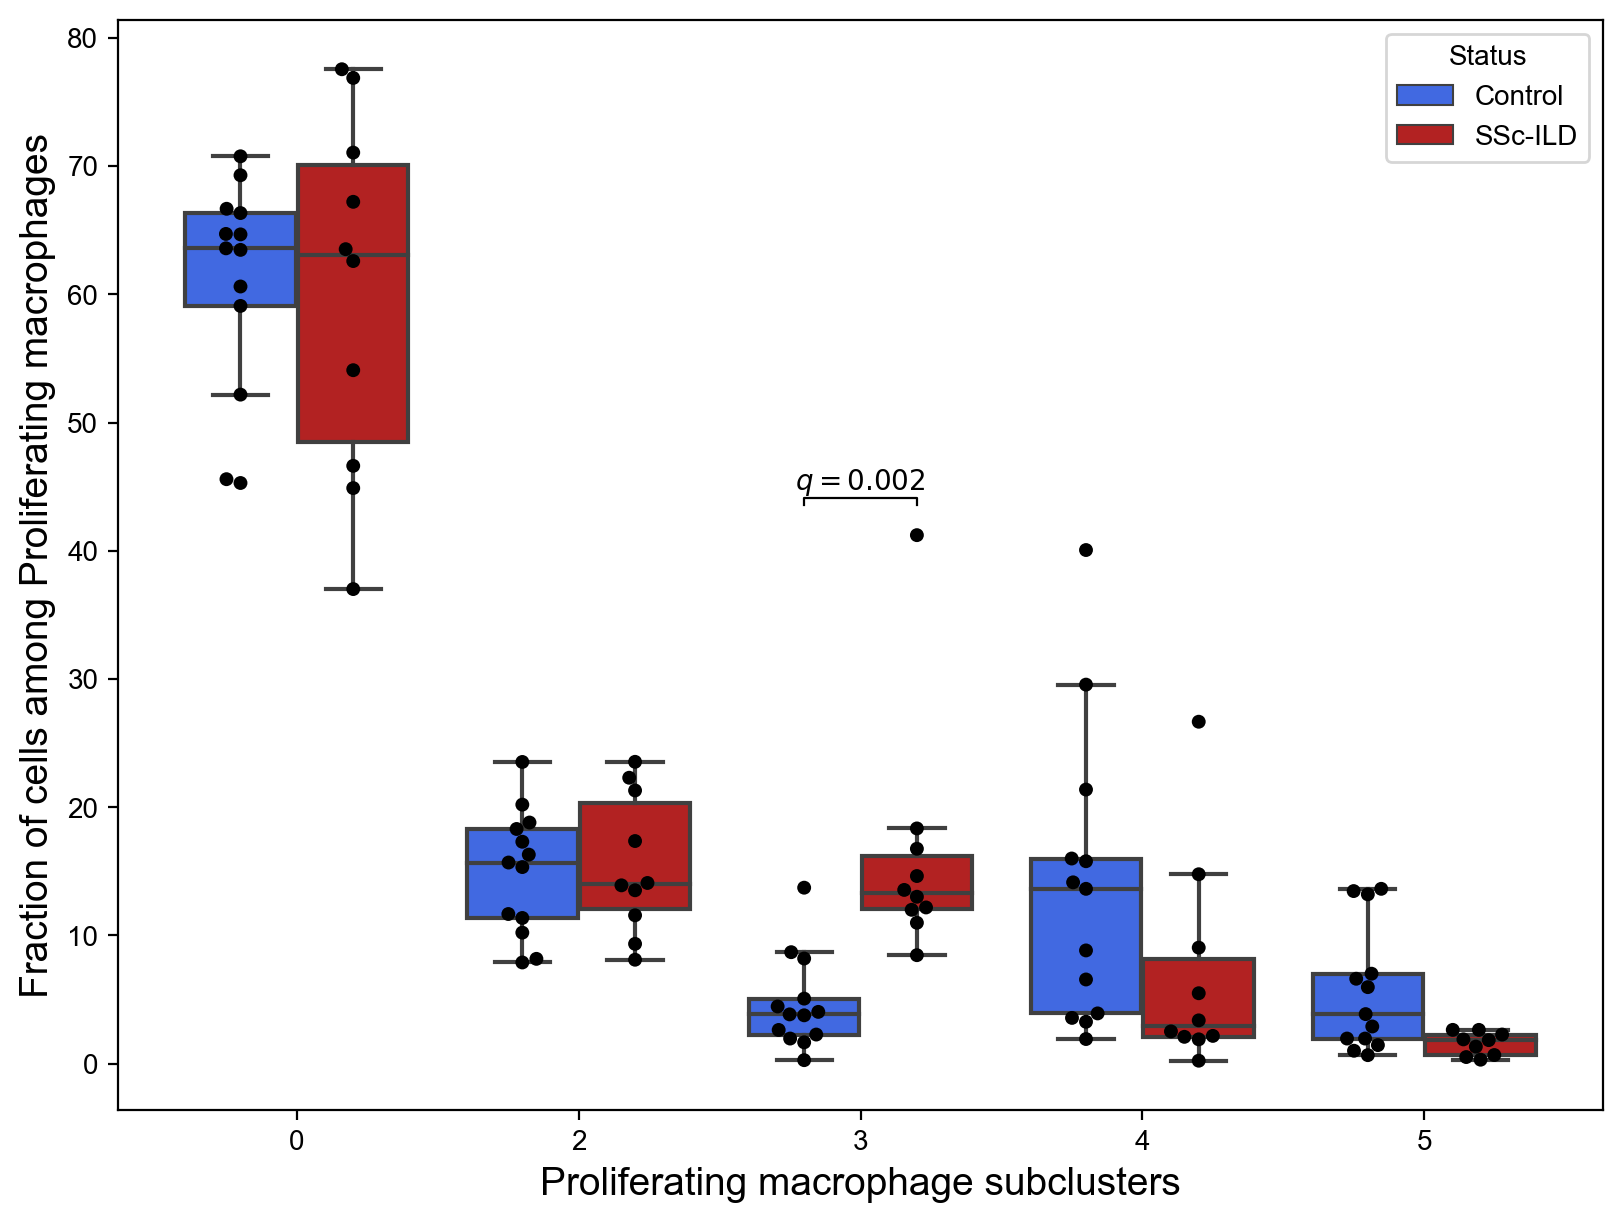

In [150]:
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
sns.boxplot(
    data=counts_merged,
    x='leiden',
    y='percent_in_sample',
    hue='Status',
    palette=['royalblue', 'firebrick'],
    saturation=1,
    showfliers=False,
    # linecolor='k',
    ax=ax
)
sns.swarmplot(
    data=counts_merged,
    x='leiden',
    y='percent_in_sample',
    hue='Status',
    dodge=True,
    palette=['k', 'k'],
    # jitter=0.2,
    legend=False,
    ax=ax
)

# Get the number of hue categories for proper positioning
n_hue_cats = len(counts_merged.Status.unique())
width = 0.8  # default width of seaborn boxplot

# Get cell type labels and their positions
cell_types = counts_merged.leiden.unique()
cell_type_positions = {ct: i for i, ct in enumerate(cell_types)}

# Get hue labels and map to their positions
hue_categories = sorted(counts_merged.Status.unique())
hue_offsets = np.linspace(0, width - width / n_hue_cats, n_hue_cats) + width / (2 * n_hue_cats) - width / 2

start_height = counts_merged.groupby('leiden')['percent_in_sample'].max().to_dict()
incrementer = 15 # px
q = ax.transData.inverted().transform([[0, 0], [0, incrementer]])
y_offset = q[1][1] - q[0][1]
gap = y_offset / 4

# Add annotations for significant comparisons
for _, r in stat_results_sign.iterrows():
    cell_type = r.value
    base_x = cell_type_positions[cell_type]
    base_y = start_height[cell_type]

    # Get the x positions for each hue level within this cell type
    hue1_idx = hue_categories.index(r.group1)
    hue2_idx = hue_categories.index(r.group2)
    x1 = base_x + hue_offsets[hue1_idx]
    x2 = base_x + hue_offsets[hue2_idx]

    # Format p-value
    p_text = f'$q={r.pval_adj:.3f}$'

    # Add bracket and annotation
    y = base_y + y_offset
    ax.plot([x1, x1, x2, x2], [y, y+gap, y+gap, y], lw=0.8, c='k')
    ax.text((x1+x2)/2, y+gap, p_text, ha='center', va='bottom', fontsize=10)

    # Increment height for next annotation if needed
    start_height[cell_type] += y_offset

ax.set_ylabel('Fraction of cells among Proliferating macrophages', size=14)
ax.set_xlabel('Proliferating macrophage subclusters', size=14)